[View in Colaboratory](https://colab.research.google.com/github/XinyueZ/tf/blob/master/ipynb/price_rooms_estimator_clean_data.ipynb)

# This case is a ML model about the linear relationship between "average housing area" and "price per housing area".

In [0]:
import tensorflow as tf
from tensorflow.python.data import Dataset
import sklearn
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [0]:
STEPS = 5000  # Steps of train loop. 
PERIODS = 20
STEPS_PER_PERIOD = STEPS / PERIODS
LEARNING_RATE = 0.000001
BINS = 150

In [0]:
tf.logging.set_verbosity(tf.logging.INFO)

In [925]:
source = pd.read_csv("https://dl.dropbox.com/s/e2tcsgbcp2in5h5/price_rooms_area.tsv", sep="\t")
source.head()

,PRICE,ROOMS,AREA,OBJECTCAT,MARKETINGTYPE
0,5,0,249,Sonstiges Büro-/Praxisobjekt,Miete
1,595000,9,440,Besondere Immobilie,Kauf
2,199000,6,"135,75",Stadthaus,Kauf
3,269000,9,"203,57",Stadthaus,Kauf
4,562,3,"63,15",Etagenwohnung,Miete


# Clean the data-source
- Remove rows containing *null*
- Remove rows containing *N/A*
- Add New data columns: "Average housing area" and "per housing area price".
- Clean new added columns

In [0]:
def clean_data(source):
  df = source
  
  # Remove null rows
  df = df[pd.notnull(df["PRICE"])]
  df = df[pd.notnull(df["ROOMS"])]
  df = df[pd.notnull(df["AREA"])]
  
  # Remove useless columns
  df = df.drop(["OBJECTCAT"], axis=1)
  df = df[~df["MARKETINGTYPE"].isin(["Miete"])]
  df = df.drop(["MARKETINGTYPE"], axis=1)
  
  # Convert all strings to numeric
  df = df.convert_objects(convert_numeric=True)
  
  # Remove rows containing a "0", i.e price = 0 or rooms = 0
  df = df[~(df[["PRICE", "ROOMS","AREA"]] == 0)]
  
  # Remove rows containing N/A 
  df = df[pd.notna(df["PRICE"])]
  df = df[pd.notna(df["ROOMS"])]
  df = df[pd.notna(df["AREA"])]

  # Insert new column of "price of pro-area"
  df.insert(1, "PRICE_PRO_AREA", df["PRICE"] / df["AREA"]) 
  df = df[~(df["PRICE_PRO_AREA"] < 5)]
  #df["PRICE_PRO_AREA"] = df["PRICE_PRO_AREA"] / 1000 #Scale -1000 for easy demo.
  df["PRICE_PRO_AREA"] = np.log(df["PRICE_PRO_AREA"])
  df = df[pd.notnull(df["PRICE_PRO_AREA"])]
  df = df[pd.notna(df["PRICE_PRO_AREA"])]
    
  # Insert new column of "area of each room"
  df.insert(4, "AREA_PRO_ROOM", df["AREA"] / df["ROOMS"]) 
  df = df[~(df["AREA_PRO_ROOM"] < 1)]
  df["AREA_PRO_ROOM"] = np.log(df["AREA_PRO_ROOM"])
  df = df[pd.notnull(df["AREA_PRO_ROOM"])]
  df = df[pd.notna(df["AREA_PRO_ROOM"])]
  
  return df

In [927]:
df = clean_data(source)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [928]:
df.head()

,PRICE,PRICE_PRO_AREA,ROOMS,AREA,AREA_PRO_ROOM
1,595000.0,7.209542,9.0,440.0,3.889550
5,299000.0,7.666556,5.0,140.0,3.332205
6,685000.0,7.497003,8.0,380.0,3.860730
8,206000.0,6.600842,1.0,280.0,5.634790
9,75000.0,7.114370,3.0,61.0,3.012262


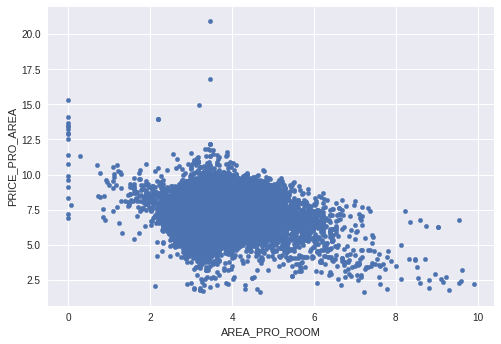

In [929]:
df.plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [0]:
def make_dataset_and_labels_and_class_num(df, label_name):
  """This method will prepare da, labels for train, evaluation, test.
     Args:
      df: DataFrame format of datasource.
      label_name: The name of column in datasource which will be as target for train.
     Return: 
       Tuple of (ds_train, ds_eval, ds_test, label_train, label_eval, label_test)
      
  """
  target_label_col = label_name
   
  random_seed = None
  np.random.seed(random_seed)
  
  ds_train = df.sample(frac=0.7, random_state=random_seed)
  label_train = ds_train[[target_label_col]]
  
  ds_rest = df.drop(ds_train.index)
  ds_rest = ds_rest.copy()
  
  ds_eval = ds_rest.sample(frac=0.7, random_state=random_seed)
  label_eval = ds_eval[[target_label_col]]
  
  ds_test = ds_rest.drop(ds_eval.index)
  label_test = ds_test[[target_label_col]]
  
  return ds_train[["AREA_PRO_ROOM"]], ds_eval[["AREA_PRO_ROOM"]], ds_test[["AREA_PRO_ROOM"]], label_train, label_eval, label_test

In [0]:
x_train, x_eval, x_test, y_train, y_eval, y_test = make_dataset_and_labels_and_class_num(df, "PRICE_PRO_AREA")

In [932]:
x_train.describe()

,AREA_PRO_ROOM
count,89726.000000
mean,3.452166
std,0.425583
min,0.000000
25%,3.218876
50%,3.394508
75%,3.604138
max,9.581904


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f032423c6a0>]],
      dtype=object)

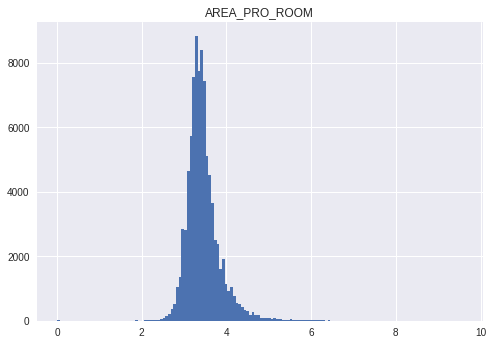

In [933]:
x_train.hist("AREA_PRO_ROOM", bins = BINS)

In [934]:
y_train.describe()

,PRICE_PRO_AREA
count,89726.000000
mean,7.525239
std,0.733379
min,1.629641
25%,7.130899
50%,7.561682
75%,7.964124
max,20.960654


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0314424160>]],
      dtype=object)

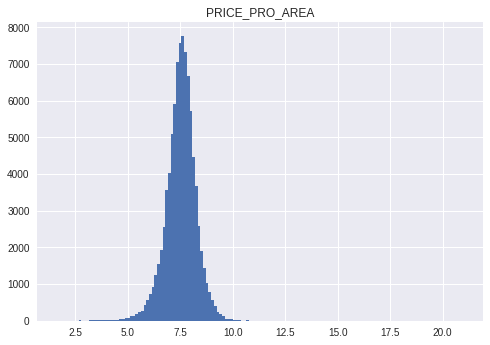

In [935]:
y_train.hist("PRICE_PRO_AREA", bins=BINS)

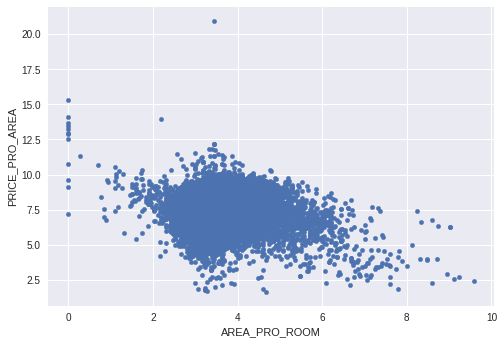

In [936]:
pd.concat([x_train, y_train], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA') 

In [937]:
x_eval.describe()

,AREA_PRO_ROOM
count,26918.000000
mean,3.452510
std,0.431524
min,0.000000
25%,3.218876
50%,3.401197
75%,3.608042
max,9.903488


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f031b759908>]],
      dtype=object)

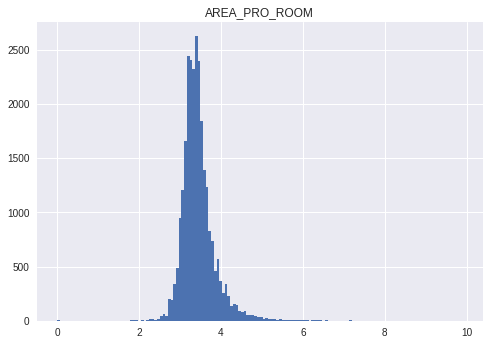

In [938]:
x_eval.hist("AREA_PRO_ROOM", bins = BINS)

In [939]:
y_eval.describe()

,PRICE_PRO_AREA
count,26918.000000
mean,7.524879
std,0.739413
min,1.666556
25%,7.130899
50%,7.566274
75%,7.964774
max,16.762453


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f031918f668>]],
      dtype=object)

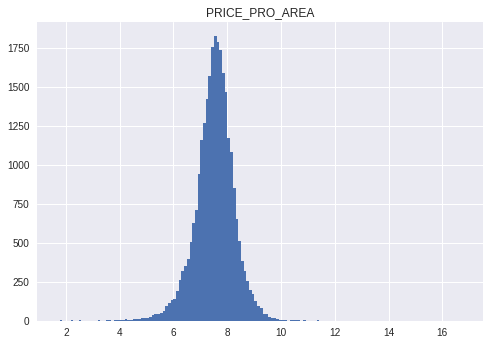

In [940]:
y_eval.hist("PRICE_PRO_AREA", bins=BINS)

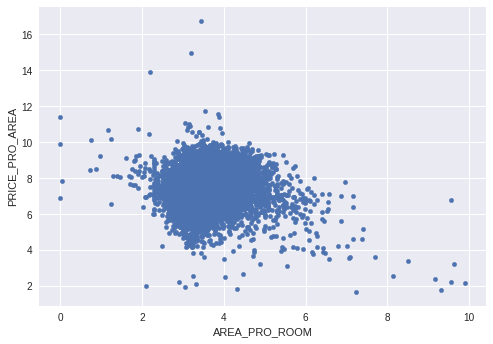

In [941]:
pd.concat([x_eval, y_eval], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [942]:
x_test.describe()

,AREA_PRO_ROOM
count,11536.000000
mean,3.451022
std,0.422136
min,0.000000
25%,3.218876
50%,3.389694
75%,3.605498
max,8.817076


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0306ed5c88>]],
      dtype=object)

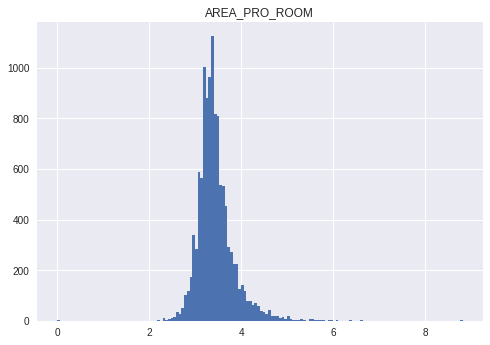

In [943]:
x_test.hist("AREA_PRO_ROOM", bins=BINS)

In [944]:
y_test.describe()

,PRICE_PRO_AREA
count,11536.000000
mean,7.513526
std,0.725805
min,1.951409
25%,7.120260
50%,7.554548
75%,7.957577
max,13.920871


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f02fe70a7b8>]],
      dtype=object)

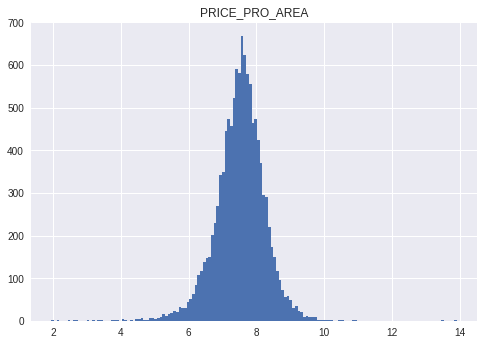

In [945]:
y_test.hist("PRICE_PRO_AREA", bins=BINS)

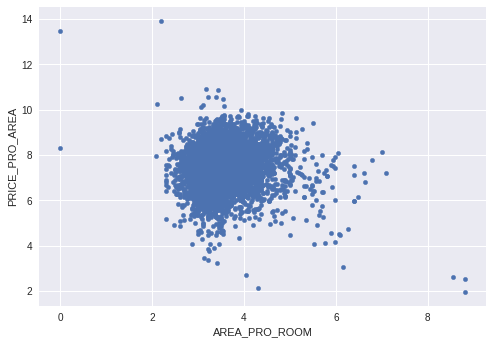

In [946]:
pd.concat([x_test, y_test], axis=1).plot.scatter(x='AREA_PRO_ROOM', y='PRICE_PRO_AREA')

In [947]:
x_train.head()

,AREA_PRO_ROOM
277111,2.890372
263945,3.401197
76539,2.674149
141588,2.959365
118596,3.028522


In [948]:
x_eval.head()

,AREA_PRO_ROOM
143666,3.360375
290835,3.178054
38680,3.828641
294022,3.044522
185924,3.912023


In [949]:
x_test.head()

,AREA_PRO_ROOM
19,3.516508
42,3.308107
66,3.352407
134,3.555348
145,2.988564


In [950]:
y_train.head()

,PRICE_PRO_AREA
277111,8.489022
263945,6.279147
76539,7.547793
141588,6.384507
118596,7.211438


In [951]:
y_eval.head()

,PRICE_PRO_AREA
143666,7.049930
290835,7.013116
38680,7.237684
294022,7.647422
185924,7.185387


In [952]:
y_test.head()

,PRICE_PRO_AREA
19,7.303270
42,7.406311
66,7.803843
134,9.456084
145,7.494742


In [0]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
 
    # Construct a dataset, and configure batching/repeating
    features = {key:np.array(value) for key,value in dict(features).items()} 
  
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
train_input_fn = lambda: input_fn(x_train, y_train)

In [0]:
train_predict_input_fn = lambda: input_fn(x_train, y_train, num_epochs=1, shuffle=False)

In [0]:
eval_predict_input_fn = lambda: input_fn(x_eval, y_eval, num_epochs=1, shuffle=False)

In [0]:
test_predict_input_fun = lambda: input_fn(x_test, y_test, num_epochs=1, shuffle=False)

In [0]:
feature_cols = [
  tf.feature_column.numeric_column("AREA_PRO_ROOM") 
]

In [0]:
train_optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_optimizer = tf.contrib.estimator.clip_gradients_by_norm(train_optimizer, 5.0)

In [960]:
model = tf.estimator.LinearRegressor(
    feature_columns = feature_cols,
    optimizer = train_optimizer
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_ah3hmh0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f030e0e92b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
for period in range(0, PERIODS):
  model.train(input_fn=train_input_fn, steps=STEPS)
  train_predict = model.predict(input_fn=train_predict_input_fn)
  eval_predict = model.predict(input_fn=eval_predict_input_fn)
  print("-" * 100)
  model.evaluate(steps=STEPS, input_fn=train_predict_input_fn)
  model.evaluate(steps=STEPS, input_fn=eval_predict_input_fn) 
  print("-" * 100)
  
  train_predict = np.array([item['predictions'][0] for item in train_predict])
  eval_predict = np.array([item['predictions'][0] for item in eval_predict])
  
  # Compute loss for train and evaluation
  train_rmse = math.sqrt(
        sklearn.metrics.mean_squared_error(train_predict, y_train))
  eval_rmse = math.sqrt(
        sklearn.metrics.mean_squared_error(eval_predict, y_eval))
  
  print("*" * 100)
  print("*Period[rmse training] %02d : %0.2f" % (period, train_rmse))
  print("*Period[rmse eval] %02d : %0.2f" % (period, eval_rmse))  
  print("*" * 100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp_ah3hmh0/model.ckpt.
INFO:tensorflow:loss = 52.31886, step = 0
INFO:tensorflow:global_step/sec: 381.731
INFO:tensorflow:loss = 63.17144, step = 100 (0.266 sec)
INFO:tensorflow:global_step/sec: 462.001
INFO:tensorflow:loss = 48.58613, step = 200 (0.218 sec)
INFO:tensorflow:global_step/sec: 448.041
INFO:tensorflow:loss = 63.463947, step = 300 (0.223 sec)
INFO:tensorflow:global_step/sec: 449.524
INFO:tensorflow:loss = 53.613697, step = 400 (0.223 sec)
INFO:tensorflow:global_step/sec: 396.072
INFO:tensorflow:loss = 65.2357, step = 500 (0.252 sec)
INFO:tensorflow:global_step/sec: 441.304
INFO:tensorflow:loss = 79.94946, step = 600 (0.226 sec)
INFO:tensorflow:global_step/sec: 447.867
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 444.42
INFO:tensorflow:loss = 62.62877, step = 2900 (0.225 sec)
INFO:tensorflow:global_step/sec: 444.424
INFO:tensorflow:loss = 43.052307, step = 3000 (0.225 sec)
INFO:tensorflow:global_step/sec: 446.507
INFO:tensorflow:loss = 53.42156, step = 3100 (0.224 sec)
INFO:tensorflow:global_step/sec: 400.29
INFO:tensorflow:loss = 44.635864, step = 3200 (0.251 sec)
INFO:tensorflow:global_step/sec: 410.654
INFO:tensorflow:loss = 56.53228, step = 3300 (0.242 sec)
INFO:tensorflow:global_step/sec: 459.555
INFO:tensorflow:loss = 60.184196, step = 3400 (0.218 sec)
INFO:tensorflow:global_step/sec: 442.458
INFO:tensorflow:loss = 56.381447, step = 3500 (0.226 sec)
INFO:tensorflow:global_step/sec: 434.62
INFO:tensorflow:loss = 54.16626, step = 3600 (0.230 sec)
INFO:tensorflow:global_step/sec: 444.378
INFO:tensorflow:loss = 54.262173, step = 3700 (0.222 sec)
INFO:tensorflow:global_step/sec: 404.974
INFO:tensorflow:loss = 58.548862, step = 3800 (0.248 sec)
INFO:tensorflow:g

INFO:tensorflow:Saving dict for global step 5000: average_loss = 55.840614, global_step = 5000, loss = 55.840614
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmp_ah3hmh0/model.ckpt-5000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-03-16:47:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp_ah3hmh0/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [500/5000]
INFO:tensorflow:Evaluation [1000/5000]
INFO:tensorflow:Evaluation [1500/5000]
INFO:tensorflow:Evaluation [2000/5000]
INFO:tensorflow:Evaluation [2500/5000]
INFO:tensorflow:Evaluation [3000/5000]
INFO:tensorflow:Evaluation [3500/5000]
INFO:tensorflow:Evaluation [4000/5000]
INFO:tensorflow:Evaluation [4500/5000]
INFO:tensorflow:Evaluation [5000/5000]
INFO:tensorflow:Finished evaluation at 2018-08-03-16:47:27
INFO:ten

In [0]:
test_predict = model.predict(input_fn=test_predict_input_fun)
print("-" * 100)
model.evaluate(steps=STEPS, input_fn=test_predict_input_fun)
print("-" * 100)
test_predict = np.array([item['predictions'][0] for item in test_predict])  
test_rmse = math.sqrt(
        sklearn.metrics.mean_squared_error(test_predict, y_test))
print("*" * 100)
print("*Final[rmse test] %02d : %0.2f" % (period, test_rmse))
print("*" * 100)

In [0]:
test_predict = np.array([item["predictions"][0] for item in test_predict])

In [0]:
test_predict